In [1]:
from binance.client import Client
import time
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import ta

In [2]:
# Binance API keys
API_KEY = '3KKoPw7y0uHyLzFVnwxu6gsXFQfBEDwnoLDpKjbh41UgvbB3LukYx0zhsG5l1xev'
API_SECRET = 'PmJwK0lzZiQ5cCEW2aypB8Eska7bHiJ3gmOY6WyetmTm7C7FxCKBkfvYJR3Wzhky'

# Initialize Binance client
client = Client(API_KEY, API_SECRET)

In [3]:
client

In [4]:
def getDate(symbol):
    # Get 1 day candlestick data for the last 1 year
    klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY)
    df = pd.DataFrame(klines, columns=['time', 'open', 'high', 'low', 'close', 'volume', 
                                       'close_time', 'quote_asset_volume', 'trades', 
                                       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['close'] = df['close'].astype(float)
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['volume'] = df['volume'].astype(float)
    return df[['time', 'open', 'high', 'low', 'close', 'volume']]

In [5]:
# getDate('BTCUSDT')
# getDate('ETHUSDT')
getDate('ADAUSDT')


,time,open,high,low,close,volume
0,2022-03-08,0.7930,0.8210,0.7870,0.8020,124187499.5
1,2022-03-09,0.8020,0.8630,0.7990,0.8490,114971836.5
2,2022-03-10,0.8490,0.8540,0.7850,0.8070,115081098.3
3,2022-03-11,0.8060,0.8190,0.7820,0.7880,101514757.7
4,2022-03-12,0.7880,0.8020,0.7860,0.7890,50466434.4
...,...,...,...,...,...,...
995,2024-11-27,0.9602,1.0419,0.9312,1.0116,383499059.9
996,2024-11-28,1.0114,1.0491,0.9693,1.0321,254849669.5
997,2024-11-29,1.0321,1.0996,1.0274,1.0755,351237724.5
998,2024-11-30,1.0754,1.1498,1.0498,1.0790,369560299.2


In [6]:
def tradingLogic(symbol, qty, open_position, buy_signals, sell_signals, buyPrices, sellPrices):
    """
    Handles trading logic, calculates MACD, and executes buy/sell orders.
    Updates buy/sell signals and prices lists.
    """
    try:
        # Fetch data
        df = getDate(symbol)  # Replace with the actual data-fetching function
        
        if df.empty:
            print("No data fetched, retrying...")
            return df, open_position  # Return the unchanged state
        
        # Calculate MACD and MACD Signal
        macd_indicator = ta.trend.MACD(df['close'])
        df['macd_diff'] = macd_indicator.macd_diff()

        # Check conditions
        if not open_position:
            # Buy condition: MACD diff crosses above 0
            if df['macd_diff'].iloc[-1] > 0 and df['macd_diff'].iloc[-2] < 0:
                order = client.create_order(
                    symbol=symbol, side='BUY', type='MARKET', quantity=qty
                )
                print("\n=== BUY ORDER EXECUTED ===")
                print(f"Order Details: {order}")
                buyPrice = float(order['fills'][0]['price'])
                print(f"Bought at: {buyPrice}")
                
                open_position = True
                buy_signals.append(df['time'].iloc[-1])
                buyPrices.append(buyPrice)
        else:
            # Sell condition: MACD diff crosses below 0
            if df['macd_diff'].iloc[-1] < 0 and df['macd_diff'].iloc[-2] > 0:
                order = client.create_order(
                    symbol=symbol, side='SELL', type='MARKET', quantity=qty
                )
                print("\n=== SELL ORDER EXECUTED ===")
                print(f"Order Details: {order}")
                sellPrice = float(order['fills'][0]['price'])
                print(f"Sold at: {sellPrice}")
                
                profit = (sellPrice - buyPrices[-1]) / buyPrices[-1] * 100
                print(f"Profit: {profit:.2f}%")
                
                open_position = False
                sell_signals.append(df['time'].iloc[-1])
                sellPrices.append(sellPrice)
                
        return df, open_position  # Return updated state
    except Exception as e:
        print(f"Error in trading logic: {e}")
        return pd.DataFrame(), open_position  # Return an empty DataFrame and the unchanged state


In [7]:
def plotGraph(df, buy_signals, buyPrices, sell_signals, sellPrices, symbol):
    """
    Plots the price data, MACD indicators, and buy/sell signals.
    """
    try:
        plt.figure(figsize=(12, 6))
        
        # Price chart
        plt.subplot(2, 1, 1)
        plt.plot(df['time'], df['close'], label='Price', color='blue')
        plt.scatter(buy_signals, buyPrices, marker='^', color='green', label='Buy Signal', alpha=1)
        plt.scatter(sell_signals, sellPrices, marker='v', color='red', label='Sell Signal', alpha=1)
        plt.title(f'{symbol} Price with Buy/Sell signals')
        plt.legend()
        
        # MACD chart
        plt.subplot(2, 1, 2)
        plt.plot(df['time'], df['macd_diff'], label='MACD Diff', color='orange')
        plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
        plt.title('MACD Difference')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in plotting graph: {e}")


In [8]:
def tradingGraph(symbol, qty, open_position=False):
    """
    Main function to coordinate trading logic and plotting.
    After showing the graph, print buy/sell order details.
    """
    buy_signals = []
    sell_signals = []
    buyPrices = []
    sellPrices = []
    
    try:
        while True:
            # Trading logic
            df, open_position = tradingLogic(
                symbol, qty, open_position, buy_signals, sell_signals, buyPrices, sellPrices
            )
            
            # Ensure data is valid for plotting
            if not df.empty:
                plotGraph(df, buy_signals, buyPrices, sell_signals, sellPrices, symbol)
                
                # Print buy/sell order details after the graph
                if buy_signals:
                    print("\n=== Latest Buy Order ===")
                    print(f"Buy Price: {buyPrices[-1]}")
                    print(f"Buy Time: {buy_signals[-1]}")
                
                if sell_signals:
                    print("\n=== Latest Sell Order ===")
                    print(f"Sell Price: {sellPrices[-1]}")
                    print(f"Sell Time: {sell_signals[-1]}")
            
            # Wait before next iteration
            time.sleep(60)  # Adjust this interval as needed
    except Exception as e:
        print(f"Error in trading loop: {e}")


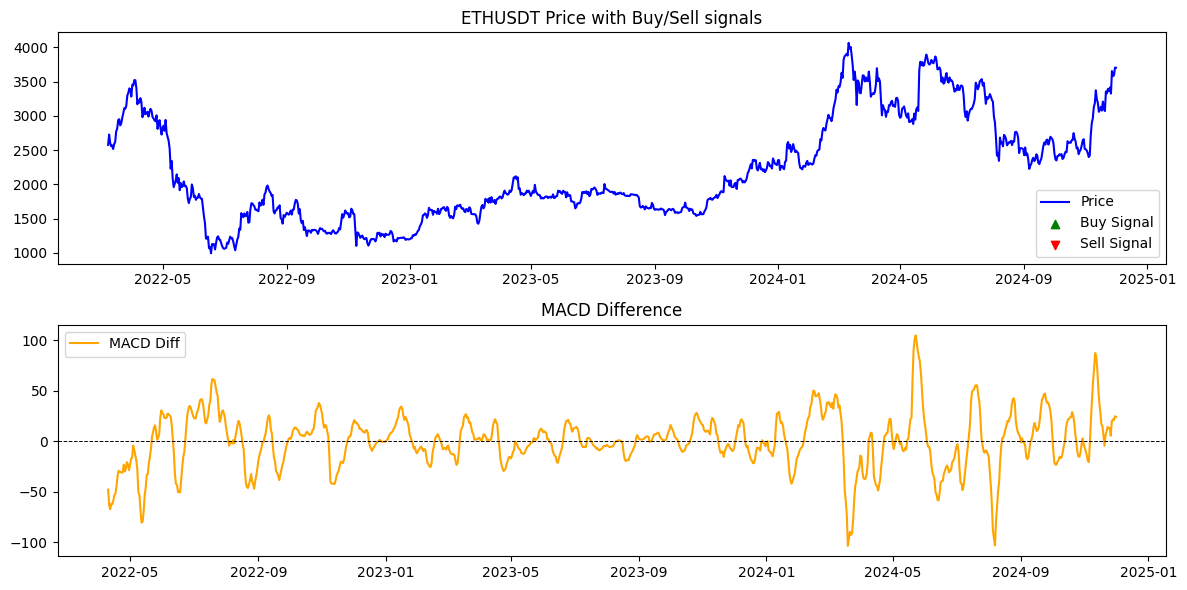

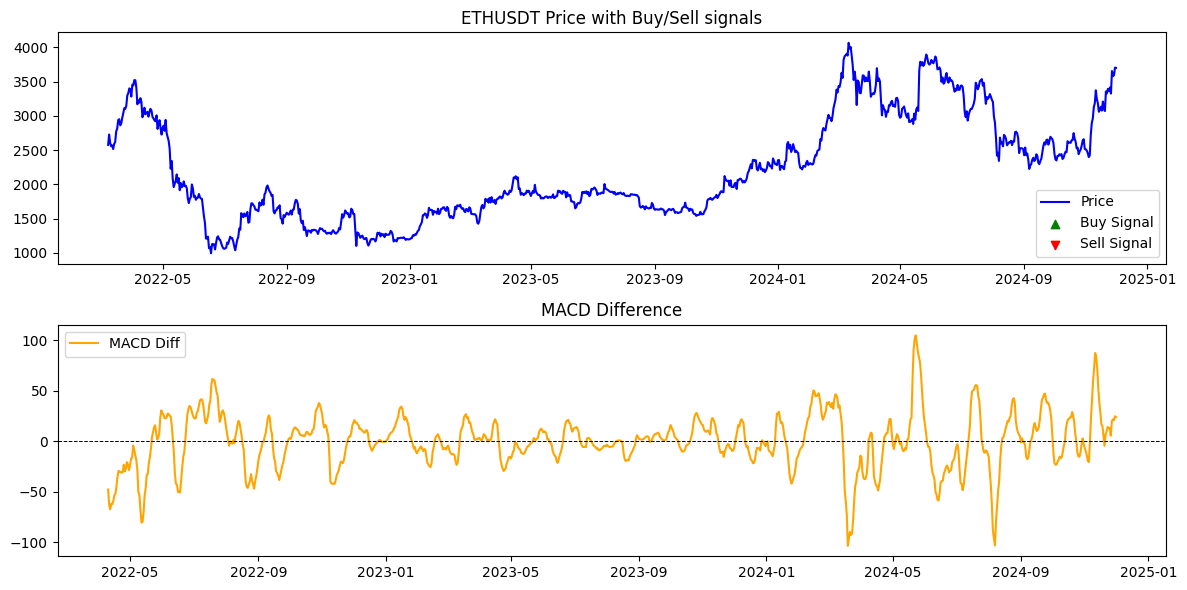

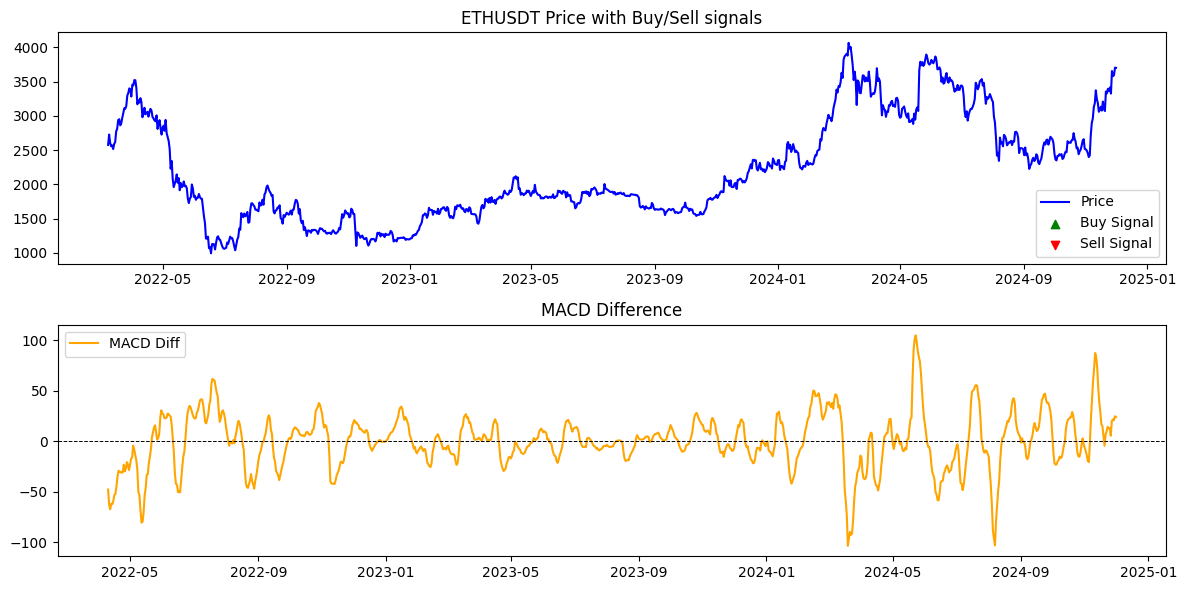

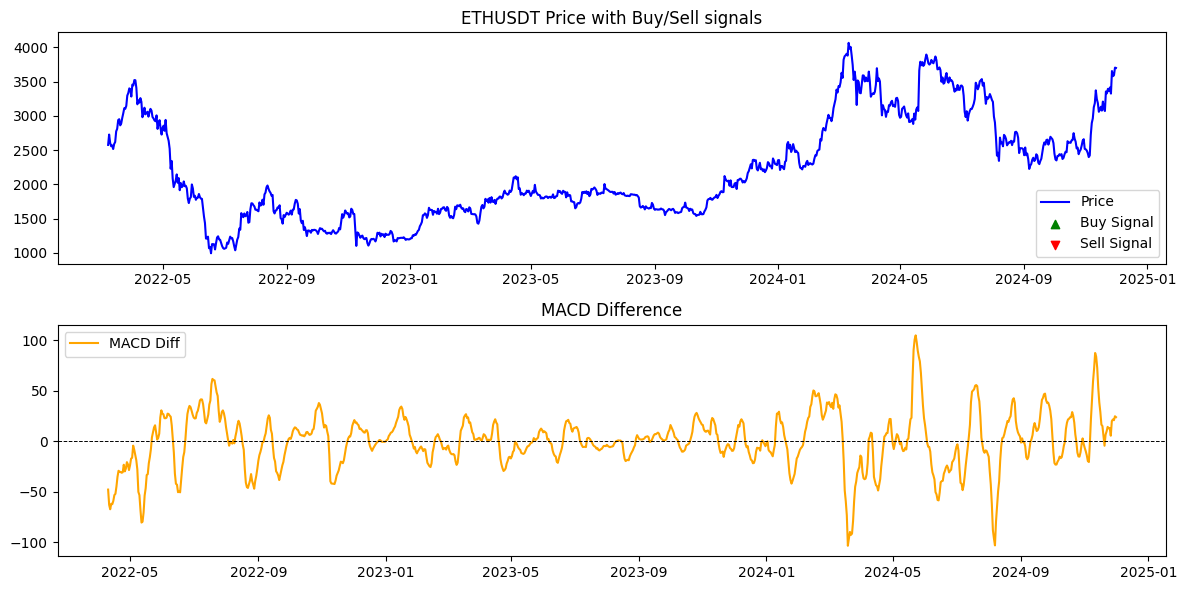

KeyboardInterrupt: 

In [9]:

tradingGraph('ETHUSDT', qty=100)